In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import resample


In [67]:
data=pd.read_csv('/content/drive/MyDrive/data/Twitter Analysis.csv')
data.head()

,Unnamed: 0,majority_target,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
0,0,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,0,5,0,1,0,33,3,5,19
1,1,True,End of eviction moratorium means millions of A...,1.0,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1621.0,31436.0,37184.0,64.0,...,0,2,1,0,0,0,14,0,2,34
2,2,True,End of eviction moratorium means millions of A...,1.0,THE SUPREME COURT is siding with super rich pr...,9.0,84.0,219.0,1184.0,0.0,...,0,1,0,0,0,0,3,0,4,10
3,3,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders\n\nBroken campaign promi...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,1,3,0,0,1,6,8,1,30
4,4,True,End of eviction moratorium means millions of A...,1.0,@OhComfy I agree. The confluence of events rig...,70.0,166.0,15282.0,2194.0,0.0,...,0,1,3,0,1,0,11,3,2,19


In [68]:
data.columns

Index(['Unnamed: 0', 'majority_target', 'statement', 'BinaryNumTarget',
       'tweet', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'following', 'embeddings', 'BotScore',
       'BotScoreBinary', 'cred', 'normalize_influence', 'mentions', 'quotes',
       'replies', 'retweets', 'favourites', 'hashtags', 'URLs', 'unique_count',
       'total_count', 'ORG_percentage', 'NORP_percentage', 'GPE_percentage',
       'PERSON_percentage', 'MONEY_percentage', 'DATE_percentage',
       'CARDINAL_percentage', 'PERCENT_percentage', 'ORDINAL_percentage',
       'FAC_percentage', 'LAW_percentage', 'PRODUCT_percentage',
       'EVENT_percentage', 'TIME_percentage', 'LOC_percentage',
       'WORK_OF_ART_percentage', 'QUANTITY_percentage', 'LANGUAGE_percentage',
       'Word count', 'Max word length', 'Min word length',
       'Average word length', 'present_verbs', 'past_verbs', 'adjectives',
       'adverbs', 'adpositions', 'pronouns', 'TOs', 'deter

In [69]:
# Prepare tweet data for model
max_words = 1000  # Max number of words to keep in Tokenizer
max_seq_length = 100  # Max sequence length for padding

In [70]:
# Separate data into '0' and '1' classes
data_0 = data[data['BotScoreBinary'] == 0]
data_1 = data[data['BotScoreBinary'] == 1]


In [71]:
# Randomly select 20,000 rows from '0' class if available
if len(data_0) > 20000:
    data_0 = data_0.sample(n=20000, random_state=42)

In [72]:
# Randomly oversample the minority class to match the majority class
data_1_oversampled = resample(data_1,
                              replace=True,    # Sample with replacement
                              n_samples=len(data_0),  # Match number of majority class
                              random_state=42)  # For reproducibility

# Combine the majority class with the oversampled minority class
data_balanced = pd.concat([data_0, data_1_oversampled])

In [73]:
# Shuffle the combined dataset to mix the samples
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
x_balanced = data_balanced.drop(columns=['BotScoreBinary'])
y_balanced = data_balanced['BotScoreBinary']

In [74]:
num_rows = y_balanced.shape[0]
print(f'Number of rows: {num_rows}')


Number of rows: 40000


In [75]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

data['tweet'] = data['tweet'].apply(clean_text)

In [76]:
# Preprocess text data (same as before)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_balanced['tweet'])
sequences_balanced = tokenizer.texts_to_sequences(x_balanced['tweet'])
x_text_balanced = pad_sequences(sequences_balanced, maxlen=max_seq_length)

In [77]:
scaler = StandardScaler()

In [78]:
numeric_features = [
    'retweets',
    'mentions',
    'hashtags',
    'ORG_percentage',
    'PERSON_percentage'
]

In [79]:
import joblib
# Save the scaler to a file
scaler_filename = "function2_scaler.pkl"
joblib.dump(scaler, scaler_filename)

['function2_scaler.pkl']

In [80]:
# Scale numeric features (same as before)
x_numeric_balanced = data_balanced[numeric_features].values
x_numeric_balanced_scaled = scaler.fit_transform(x_numeric_balanced)

In [81]:
# Split balanced data into training and testing sets
x_train_text, x_test_text, x_train_numeric, x_test_numeric, y_train, y_test = train_test_split(
    x_text_balanced, x_numeric_balanced_scaled, y_balanced, test_size=0.2, random_state=42)

In [82]:
# Define model parameters
embedding_dim = 128
lstm_units = 64
dense_units = 64
dropout_rate = 0.2
l2_lambda = 0.01
max_seq_length = 100
max_words = 1000
num_numeric_features = 5

In [83]:
# Define text input (tweets)
text_input = Input(shape=(max_seq_length,), name='text_input')  # (100,)
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length)(text_input)
lstm_layer = LSTM(units=lstm_units, return_sequences=False)(embedding_layer)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [84]:
# Define numeric input (other features)
numeric_input = Input(shape=(num_numeric_features,), name='numeric_input')  # (5,)
dense_layer_numeric = Dense(units=dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(numeric_input)


In [85]:
# Combine LSTM output and numeric features
combined = concatenate([lstm_layer, dense_layer_numeric])

# Add additional dense layers
dense_combined = Dense(units=dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(combined)
dropout_combined = Dropout(rate=dropout_rate)(dense_combined)

# Output layer for binary classification
output = Dense(units=1, activation='sigmoid')(dropout_combined)

In [86]:
# Define the model
model = Model(inputs=[text_input, numeric_input], outputs=output)


In [87]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 100, 128)       │        128,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_input             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │         49,408 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │            384 │ numeric_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128)            │              0 │ lstm_2[0][0],          │
│ (Concatenate)             │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 186,113 (727.00 KB)

 Trainable params: 186,113 (727.00 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [89]:
# Train the model
history = model.fit(
    [x_train_text, x_train_numeric],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 59s 139ms/step - accuracy: 0.5630 - loss: 1.0674 - val_accuracy: 0.6461 - val_loss: 0.6429
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - accuracy: 0.6804 - loss: 0.6092 - val_accuracy: 0.6722 - val_loss: 0.6084
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 56s 139ms/step - accuracy: 0.7405 - loss: 0.5457 - val_accuracy: 0.7200 - val_loss: 0.5704
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - accuracy: 0.7744 - loss: 0.4897 - val_accuracy: 0.7372 - val_loss: 0.5513
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - accuracy: 0.8100 - loss: 0.4389 - val_accuracy: 0.7592 - val_loss: 0.5285
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 55s 138ms/step - accuracy: 0.8373 - loss: 0.3888 - val_accuracy: 0.7756 - val_loss: 0.5064
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 133ms/step - accuracy: 0.8655 - loss: 0.3423 - val_accuracy: 0.7966 - val_loss: 0.4881
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 54s 134ms/step - accuracy: 0.8838 - loss: 0

In [90]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate([x_test_text, x_test_numeric], y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8520 - loss: 0.4302
Test Accuracy: 0.8486


In [91]:
train_loss, train_accuracy = model.evaluate([x_train_text, x_train_numeric], y_train)
print(f"train Accuracy: {train_accuracy:.4f}")

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9511 - loss: 0.1694
train Accuracy: 0.9338


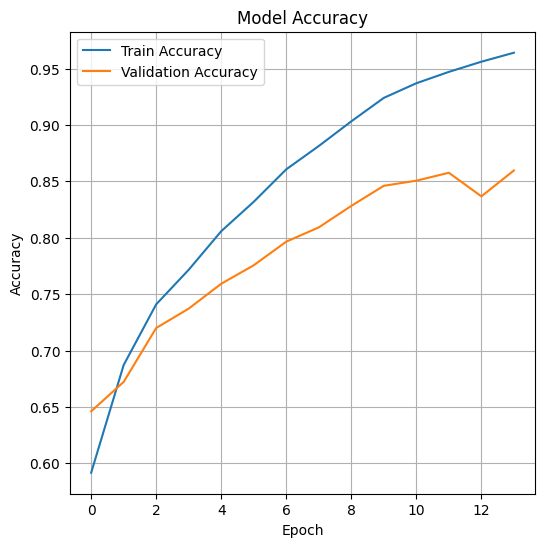

In [92]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


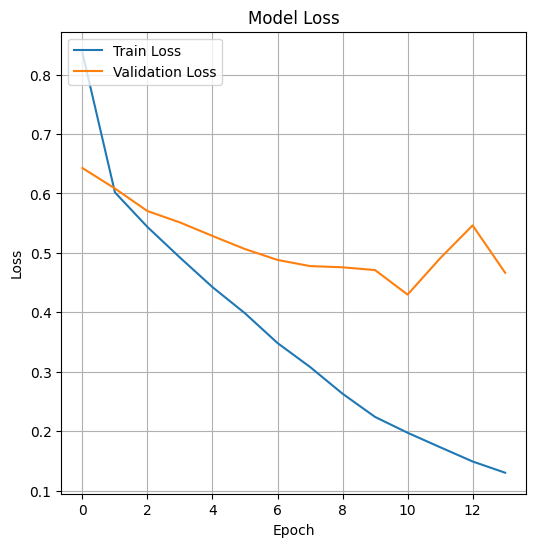

In [93]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [94]:

print("x_test_text shape:", x_test_text.shape)    # Expected: (num_samples, max_seq_length)
print("x_test_numeric shape:", x_test_numeric.shape) # Expected: (num_samples, number_of_numeric_features)


x_test_text shape: (8000, 100)
x_test_numeric shape: (8000, 5)


In [96]:
# Predict on test set
y_pred = model.predict([x_test_text, x_test_numeric])
y_pred_classes = (y_pred > 0.5).astype(int)

250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step


In [97]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[3263  734]
 [ 477 3526]]


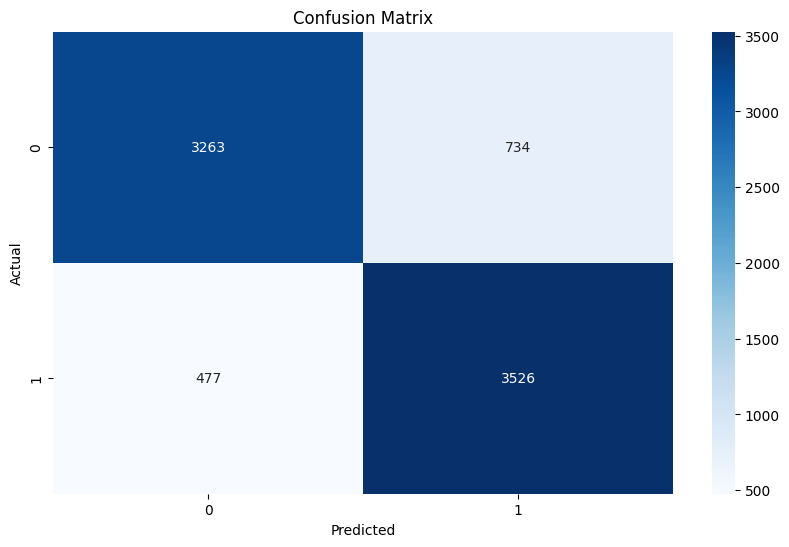

In [98]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [99]:
model.save('twitter_bot_detection_model.h5')


**Re-Training process**

In [100]:
custom_data  = pd.read_csv('/content/drive/MyDrive/Dataset/updated_tweets.csv')
custom_data .head()

,date,text,link,likes,retweets,comments,user_name,user_username,user_avatar,label,...,word_count,adjectives,adverbs,pronouns,capitals,digits,hashtags,URLs,ORG_percentage,PERSON_percentage
0,"Jan 9, 2021 · 12:41 PM UTC",ඔබට ඔබගේ #hashtag #retweet කරගැනීමට අවශ්‍ය නම්...,https://twitter.com/SLRTBot/status/13478862284...,97,34,21,SL RT Bot 🇱🇰🤖,@SLRTBot,https://pbs.twimg.com/profile_images/134775335...,1,...,9,1,0,0,3,0,3,0,0.0,0.0
1,"Jun 13, 2023 · 3:54 PM UTC",she made breakfast! anyone want some? #tasty...,https://twitter.com/CutestGraham/status/166864...,10,2,2,𝐴𝑠ℎ𝑙𝑒𝑦 𝐺𝑟𝑎ℎ𝑎𝑚,@CutestGraham,https://pbs.twimg.com/profile_images/164524557...,1,...,7,0,0,1,0,0,1,0,0.0,0.0
2,"Jun 13, 2023 · 4:02 PM UTC",It's #TastyTuesday and this chocolate hazelnut...,https://twitter.com/FoodlinkNY/status/16686500...,2,1,0,Foodlink,@FoodlinkNY,https://pbs.twimg.com/profile_images/133896538...,1,...,29,4,1,1,10,0,4,0,20.0,20.0
3,"Jun 13, 2023 · 4:02 PM UTC",This #TastyTuesday just got tastier! Enjoy a m...,https://twitter.com/SnarfHappens/status/166865...,2,1,0,Snarf's Sandwiches,@SnarfHappens,https://pbs.twimg.com/profile_images/131679554...,1,...,20,3,1,0,8,0,2,0,50.0,50.0
4,"Jun 13, 2023 · 5:43 PM UTC",Change your lunch plans and come have cold dri...,https://twitter.com/Hotshots_Bar/status/166867...,0,1,0,Hotshots Sports Bar and Grill,@Hotshots_Bar,https://pbs.twimg.com/profile_images/170216292...,1,...,16,0,0,1,6,0,2,0,20.0,40.0


In [101]:
column_names = custom_data .columns
print(column_names)

Index(['date', 'text', 'link', 'likes', 'retweets', 'comments', 'user_name',
       'user_username', 'user_avatar', 'label', 'mentions', 'word_count',
       'adjectives', 'adverbs', 'pronouns', 'capitals', 'digits', 'hashtags',
       'URLs', 'ORG_percentage', 'PERSON_percentage'],
      dtype='object')


In [102]:
# Ensure 'text' column contains strings
custom_data['text'] = custom_data['text'].astype(str)

# Replace NaN or missing values with empty strings
custom_data['text'] = custom_data['text'].fillna('')

In [103]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

custom_data['text'] = custom_data['text'].apply(clean_text)

In [104]:
# Separate data into '0' and '1' classes
data_00 = custom_data[custom_data['label'] == 0]
data_11 = custom_data[custom_data['label'] == 1]

In [105]:
# Randomly oversample the minority class to match the majority class
data_11_oversampled = resample(data_11,
                             replace=True,    # Sample with replacement
                            n_samples=len(data_00),  # Match number of majority class
                           random_state=42)  # For reproducibility

#Combine the majority class with the oversampled minority class
data_balanced1 = pd.concat([data_00, data_11_oversampled])

In [106]:
# Shuffle the combined dataset to mix the samples
data_balanced1 = data_balanced1.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
x_balanced1 = data_balanced1.drop(columns=['label'])
y_balanced1 = data_balanced1['label']

In [107]:
num_rows = x_balanced1.shape[0]
print(f'Number of rows: {num_rows}')

Number of rows: 400


In [108]:
data_balanced1['label'].value_counts()

,count
label,
1,200
0,200


In [109]:
# Preprocess text data (same as before)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_balanced1['text'])
sequences_balanced1 = tokenizer.texts_to_sequences(x_balanced1['text'])
x_text_balanced1 = pad_sequences(sequences_balanced1, maxlen=max_seq_length)

In [110]:
import pickle
with open('function2_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [111]:
numeric_features1 = [
    'retweets',
    'mentions',
    'hashtags',
    'ORG_percentage',
    'PERSON_percentage'
]

In [112]:
# Scale numeric features (same as before)
x_numeric_balanced1 = data_balanced1[numeric_features1].values
x_numeric_balanced_scaled1 = scaler.fit_transform(x_numeric_balanced1)

In [113]:
# Split balanced data into training and testing sets
x_train_text1, x_test_text1, x_train_numeric1, x_test_numeric1, y_train1, y_test1 = train_test_split(
    x_text_balanced1, x_numeric_balanced_scaled1, y_balanced1, test_size=0.2, random_state=42)

In [114]:
from tensorflow.keras.models import load_model

# Load the saved model
model2 = load_model('/content/twitter_bot_detection_model.h5')

In [115]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model (ensure it uses the same configuration as before)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change to a less suitable loss function


In [116]:
callbacks = [EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]

In [117]:
# Train the model
history = model2.fit(
    [x_train_text1, x_train_numeric1],
    y_train1,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5318 - loss: 1.3531 - val_accuracy: 0.6719 - val_loss: 0.8994
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7141 - loss: 0.6450 - val_accuracy: 0.7188 - val_loss: 0.6860
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8307 - loss: 0.4357 - val_accuracy: 0.7500 - val_loss: 0.5651
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9068 - loss: 0.2915 - val_accuracy: 0.7188 - val_loss: 0.5027
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9172 - loss: 0.2508 - val_accuracy: 0.7812 - val_loss: 0.4569
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9484 - loss: 0.1974 - val_accuracy: 0.8125 - val_loss: 0.4151
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.9672 - loss: 0.1488 - val_accuracy: 0.8594 - val_loss: 0.3814
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9797 - loss: 0.1264 - val_accuracy: 0.8594 - val_loss: 0

In [118]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate([x_test_text1, x_test_numeric1], y_test1)
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9031 - loss: 0.2557 
Test Accuracy: 0.9000


In [119]:
train_loss, train_accuracy = model2.evaluate([x_train_text1, x_train_numeric1], y_train1)
print(f"train Accuracy: {train_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9839 - loss: 0.0947
train Accuracy: 0.9719


In [121]:
# Predict on test set
y_pred1 = model2.predict([x_test_text1, x_test_numeric1])
y_pred_classes1 = (y_pred1 > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [122]:
# Confusion matrix
cm1 = confusion_matrix(y_test1, y_pred_classes1)
print(cm1)

[[38  4]
 [ 4 34]]


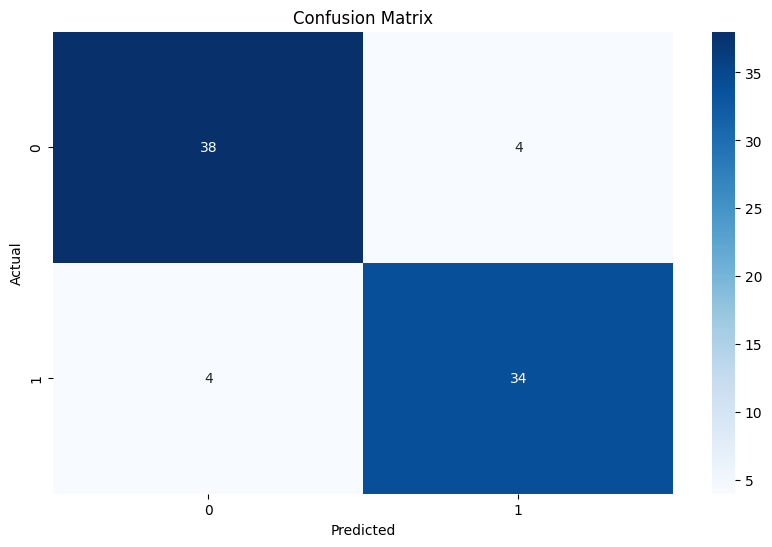

In [123]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [124]:
# Save the retrained model to a new file
model2.save('twitter_bot_detection_model_retrained.h5')
